# Description

This notebook examines whether the gap between farmer-reported and satellite-estimated yield can be predicted. Other than sowing time, each of the independent variables used is from the baseline. The CSV imported is generated from Stata. The code is in do/data_preparation.do which is called by do/main.do. The CSV is not tracked by Git, so the do file must be executed before running this notebook.

# Imports and data preparation 

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import ElasticNetCV, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

In [2]:
raw_df = pd.read_csv('../data/nosync/fr_sat_gap_analysis.csv')
raw_df.set_index('uid', inplace=True)

# Imput missing DVs to the median 
fill_NaN = SimpleImputer(strategy='median')
df = pd.DataFrame(fill_NaN.fit_transform(raw_df))
df.columns = raw_df.columns
df.index = raw_df.index

# Separate IVs and DVs
Y = df[['difference_fr_sat', 'distance_fr_sat']]
X = df.drop(columns=['difference_fr_sat', 'distance_fr_sat'])

# Split data into training and testing samples 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

y_train_diff = Y_train['difference_fr_sat']
y_test_diff = Y_test['difference_fr_sat']
y_train_dist = Y_train['distance_fr_sat']
y_test_dist = Y_test['distance_fr_sat']

# Define function to compute R2
def scoreR2(predictor, X, true_y):
    predictions = predictor.predict(X)
    return r2_score(true_y, predictions)

# Difference 

We first examine the difference between farmer-reported and satellite measured yield, $y_i = FRyield_i - SATELLITEyield_i$. We try several different models. 

## Elastic net

In [3]:
e_net_cv_diff = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv_diff.fit(X_train, y_train_diff)

print('Optimal alpha: %.8f'%e_net_cv_diff.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv_diff.l1_ratio_)
print('Number of iterations %d'%e_net_cv_diff.n_iter_)

e_net_diff = ElasticNet(l1_ratio=e_net_cv_diff.l1_ratio_, alpha = e_net_cv_diff.alpha_, 
                        max_iter=e_net_cv_diff.n_iter_, fit_intercept=True, normalize = True)
e_net_diff.fit(X_train, y_train_diff)

print("Training R^2: {}".format(scoreR2(e_net_diff, X_train, y_train_diff)))
print("Out of sample R^2: {}".format(scoreR2(e_net_diff, X_test, y_test_diff)))

Optimal alpha: 0.75646214
Optimal l1_ratio: 1.000
Number of iterations 12
Training R^2: 0.17251302885750175
Out of sample R^2: 0.12106507213120332


## Random forest 

In [4]:
#GridSearchCV
n_estimators = [300, 400, 500]  # Trees
max_features = ['sqrt']  # Max feature to consider at each split 
max_depth = [3, 4, 5]  
min_samples_split = [5, 6, 7]
min_samples_leaf = [3, 4, 5]
bootstrap = [True]

# Create the grid 
grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
        'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rf_diff_2 = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, cv=5, n_jobs = 6, scoring='r2')
rf_diff_2.fit(X_train, y_train_diff)

print(rf_diff_2.best_params_)
rf_diff_final = rf_diff_2.best_estimator_
print("Training R^2: {}".format(scoreR2(rf_diff_final, X_train, y_train_diff)))
print("Out of sample R^2: {}".format(scoreR2(rf_diff_final, X_test, y_test_diff)))

{'bootstrap': True, 'max_depth': 5, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'min_samples_split': 6, 'n_estimators': 400}
Training R^2: 0.2813694468809016
Out of sample R^2: 0.1128148856748129


## Neural net

In [5]:
scaler = StandardScaler().fit(X_train)
X_train_sc = scaler.transform(X_train)
X_test_sc = scaler.transform(X_test)

nn_diff = MLPRegressor(
    hidden_layer_sizes=(150,150,150,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.01, random_state=7)

nn_diff.fit(X_train_sc, y_train_diff)
print("Training R^2: {}".format(scoreR2(nn_diff, X_train_sc, y_train_diff)))
print("Out of sample R^2: {}".format(scoreR2(nn_diff, X_test_sc, y_test_diff)))

Training R^2: 0.21312739516083623
Out of sample R^2: 0.12041658073505579


# Distance 

We next examine whether we can predict the distance between farmer-reported and satellite yield estimates. The distance is defined as $y_i = |FRyield_i - SATELLITEyield_i|$

## Elastic net 

In [6]:
e_net_cv_dist = ElasticNetCV(l1_ratio=[.1, .5, .7, .9, .95, .99, .995, 1], eps=0.001, n_alphas=100, fit_intercept=True, 
                        normalize=True, precompute='auto', max_iter=10000, tol=0.0001, cv=5, 
                        copy_X=True, verbose=0, n_jobs=2, selection='cyclic')

e_net_cv_dist.fit(X_train, y_train_dist)

print('Optimal alpha: %.8f'%e_net_cv_dist.alpha_)
print('Optimal l1_ratio: %.3f'%e_net_cv_dist.l1_ratio_)
print('Number of iterations %d'%e_net_cv_dist.n_iter_)

e_net_dist = ElasticNet(l1_ratio=e_net_cv_dist.l1_ratio_, alpha = e_net_cv_dist.alpha_, 
                        max_iter=e_net_cv_dist.n_iter_, fit_intercept=True, normalize = True)
e_net_dist.fit(X_train, y_train_dist)

print("Training R^2: {}".format(scoreR2(e_net_dist, X_train, y_train_dist)))
print("Out of sample R^2: {}".format(scoreR2(e_net_dist, X_test, y_test_dist)))

Optimal alpha: 0.65665218
Optimal l1_ratio: 1.000
Number of iterations 6
Training R^2: 0.044068956667543624
Out of sample R^2: 0.022876674132931596


## Random forest

In [7]:
#GridSearchCV
n_estimators = [300, 400, 500]  # Trees
max_features = ['sqrt']  # Max feature to consider at each split 
max_depth = [3, 4, 5]  
min_samples_split = [5, 6, 7]
min_samples_leaf = [3, 4, 5]
bootstrap = [True]

# Create the grid 
grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth': max_depth,
        'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf, 'bootstrap': bootstrap}
rf_dist = GridSearchCV(estimator = RandomForestRegressor(), param_grid = grid, cv=5, n_jobs = 6, scoring='r2')
rf_dist.fit(X_train, y_train_dist)

print(rf_dist.best_params_)
rf_dist_final = rf_dist.best_estimator_
print("Training R^2: {}".format(scoreR2(rf_dist_final, X_train, y_train_dist)))
print("Out of sample R^2: {}".format(scoreR2(rf_dist_final, X_test, y_test_dist)))

{'bootstrap': True, 'max_depth': 4, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 7, 'n_estimators': 500}
Training R^2: 0.13147059514096893
Out of sample R^2: 0.01470606589580603


## Neural net

In [8]:
nn_dist = MLPRegressor(
    hidden_layer_sizes=(150,150,150,), activation='relu',
    early_stopping=True, learning_rate='adaptive', 
    max_iter=5000, learning_rate_init=0.01, random_state=7)

nn_dist.fit(X_train_sc, y_train_dist)
print("Training R^2: {}".format(scoreR2(nn_dist, X_train_sc, y_train_dist)))
print("Out of sample R^2: {}".format(scoreR2(nn_dist, X_test_sc, y_test_dist)))

Training R^2: 0.14485600203442162
Out of sample R^2: -0.03160799269337744


# Discussion

We are able to explain about 12% of the difference between farmer-reported and satellite-measured yields. We cannot predict the distance between the measures. Hence, we can gain some understanding of factors that may bias one of the measures, but the observables do not seem capable of predicting which farmer-reported data sources are less accurate. We next examine which features are most important in predicting the difference. 

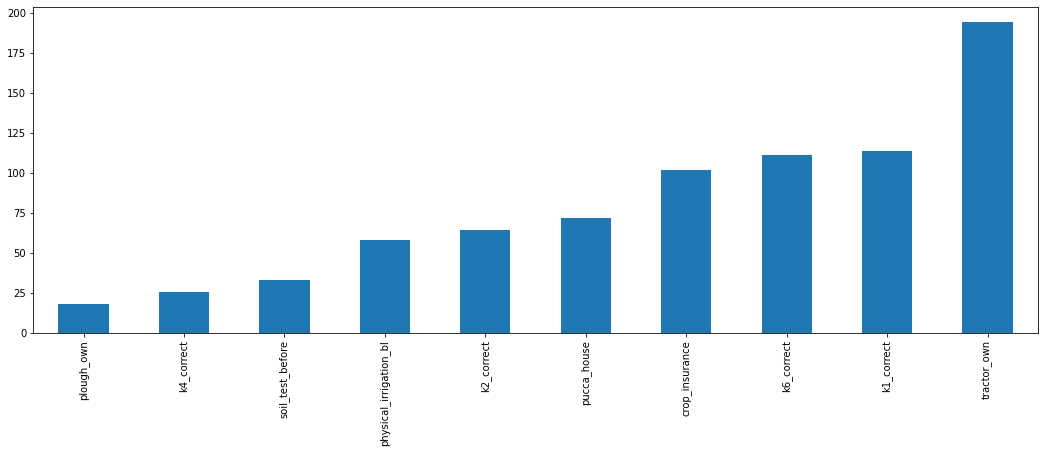

In [9]:
feature_importance = pd.Series(index = X_train.columns, data = np.abs(e_net_diff.coef_))
feature_importance.sort_values().tail(10).plot(kind = 'bar', figsize = (18,6))